<a href="https://colab.research.google.com/github/krittintrs/DL-for-PM2.5-Prediction/blob/main/DL_PM25_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change directory to my Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
os.chdir('/content/gdrive/My Drive/')
cwd = os.getcwd()
print("Files in %r: %s" % (cwd, files))

Files in '/content/gdrive/My Drive': ['.config', 'gdrive', 'sample_data']


# PM2.5 Prediction Model

## Data Preparation

### Import libraries & files

In [21]:
from keras import regularizers
from keras.callbacks import EarlyStopping ,ModelCheckpoint
from keras.models import Sequential
from math import sqrt
from scipy.interpolate import interpn
import joblib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense

dir = './ESC/DL for Air Quality Prediction/'
file_name = 'project(noday).csv'
hint = file_name[:-4]
df = pd.read_csv(dir+file_name, na_values=['-', ' '])
df = df.drop(df.columns[df.columns.str.contains('Bangna',case = False)],axis = 1) 

# filtering the missing values based on features of experiment
df_=df[(df['pm2.5'] >= 0) & (df['pm2.5_lag1']>= 0) & (df['pm2.5_lag2']>= 0)].reset_index(drop=True)

# X=input features and Y=target selection  
y=df_[['pm2.5']]

LIST=['rainfall',
      'rainfall_lag1',
      'rainfall_lag2',
      'RH',
      'wind_speed',
      'temp',
      'pm2.5_lag1',
      'pm2.5_lag2',
      #'dayofyear',
      #'weekday',
      'visibility'
      ]

x=df_[LIST]

### Normalization & Train-Test Split

In [22]:
# Normalization
scaler_list=['standard'] #'minmax','robust',
for scaler in scaler_list:
    if scaler== 'standard':
        scalerx = StandardScaler().fit(x)
        scalery = StandardScaler().fit(y)
    elif scaler == 'robust':
        scalerx = RobustScaler().fit(x)
        scalery = RobustScaler().fit(y)
    elif scaler == 'minmax':
        scalerx = MinMaxScaler(feature_range=(-1, 1)).fit(x)
        scalery = MinMaxScaler(feature_range=(-1, 1)).fit(y)
# Scale the train set
    x1 = scalerx.transform(x)
    y1 = scalery.transform(y)
    dataset_size=len(x1)
    train_data, test_data, train_targets , test_targets = train_test_split(x1, y1, test_size=0.30, random_state=3)
# save scaler
    scaler_filename = dir+'/scaler/'+scaler+'/'+hint+'/XHscaler.save'
    joblib.dump(scalerx, scaler_filename) 
    scaler_filename = dir+'/scaler/'+scaler+'/'+hint+'/YHscaler.save'
    joblib.dump(scalery, scaler_filename) 

Check Data

In [23]:
x.head()

,rainfall,rainfall_lag1,rainfall_lag2,RH,wind_speed,temp,pm2.5_lag1,pm2.5_lag2,visibility
0,0.0,0.0,0.0,59.0,8.0,27.8,39.0,34.0,10.0
1,0.0,0.0,0.0,62.0,10.0,29.2,42.0,39.0,10.0
2,0.0,0.0,0.0,63.0,8.0,30.1,42.0,42.0,10.0
3,0.0,0.0,0.0,63.0,9.0,30.0,43.0,42.0,10.0
4,0.0,0.0,0.0,69.0,8.0,29.9,32.0,43.0,10.0


In [24]:
y.head()

,pm2.5
0,42.0
1,42.0
2,43.0
3,32.0
4,23.0


## Deep Learning

In [25]:
#Project Model
from keras import models
from keras import layers

def build_model():
    opt='adam'#'rmsprop'
    model = Sequential()
    model.add(Dense(12, input_dim=train_data.shape[1], activation='relu'))
    model.add(Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.002)))
    model.add(Dense(12, activation='relu',kernel_regularizer=regularizers.l2(0.002)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
                    optimizer=opt,
                    metrics=['mae'])
    return model

In [26]:
from keras import backend as K

# Some memory clean-up
K.clear_session()

### 4-fold Validation

In [38]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 300
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    import datetime
    start_time  = datetime.datetime.now()
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
  
    test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
    end_time = datetime.datetime.now()
    print ('Select Done..., Time Cost: %d' % ((end_time - start_time).seconds)) 

processing fold # 0
2/2 [==============================] - 0s 6ms/step - loss: 0.7119 - mae: 0.6112
Select Done..., Time Cost: 66
processing fold # 1
2/2 [==============================] - 0s 6ms/step - loss: 0.5610 - mae: 0.4871
Select Done..., Time Cost: 66
processing fold # 2
2/2 [==============================] - 0s 6ms/step - loss: 0.6237 - mae: 0.5748
Select Done..., Time Cost: 82
processing fold # 3
2/2 [==============================] - 0s 9ms/step - loss: 0.6219 - mae: 0.5349
Select Done..., Time Cost: 82


Finding proper number of epochs without overfitting

In [ ]:
count = '3'
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
import matplotlib.pyplot as plt
figt = plt.gcf()
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])
figt2 = plt.gcf()
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

We found that a proper iteration is 150 epochs.

### Test Model

In [54]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
import datetime
start_time  = datetime.datetime.now()
model.fit(train_data, train_targets,epochs=50, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
end_time = datetime.datetime.now()
print ('Select Done..., Time Cost: %d' % ((end_time - start_time).seconds)) 

2/2 [==============================] - 0s 5ms/step - loss: 0.5502 - mae: 0.5236
Select Done..., Time Cost: 1


In [55]:
test_mae_score

0.523589015007019

# Best Model

## Load Model

In [61]:
# Load saved model
from keras.models import load_model
model = load_model(dir+'/scaler/'+scaler+'/'+hint+'/result/model_'+hint+'.hdf5')
print(model.summary())

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_349 (Dense)           (None, 12)                120       
                                                                 
 dense_350 (Dense)           (None, 12)                156       
                                                                 
 dense_351 (Dense)           (None, 12)                156       
                                                                 
 dense_352 (Dense)           (None, 1)                 13        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________
None


## Plotting Function

In [62]:
# RMSE calculation function
from math import sqrt
def rmse(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))
    
# MAPE calculation function
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
scalerx = joblib.load(dir+'/scaler/'+scaler+'/'+hint+'/XHscaler.save') 
scalery = joblib.load(dir+'/scaler/'+scaler+'/'+hint+'/YHscaler.save') 

In [64]:
# density_scatter plot function 

def density_scatter( x , y, ax = None, sort = True, bins = 20, figsize=(6,4), **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    x=x.reshape(len(x))
    y=y.reshape(len(y))
    if ax is None :
        fig , ax = plt.subplots(figsize=figsize)
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    cmap = matplotlib.cm.get_cmap('jet')
    normalize = matplotlib.colors.Normalize(vmin=0, vmax=max(z))#min(z)
    ax.scatter( x, y, c=z, **kwargs ,cmap=cmap)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    print(z)
    ax.plot(x,p(x),"r-")
    ax.plot(x,x,":",color='grey')
    return ax,fig,z

## Plotting Evaluation

### Evaluate with Train dataset

In [65]:
# evaluting the model using TRAIN dataset    
dfte= pd.DataFrame( columns=['features','r2','mae','rmse'])
y_pred = model.predict(train_data)
y_predinv = scalery.inverse_transform(y_pred)
y_testinv = scalery.inverse_transform(train_targets)     
mae=mean_absolute_error(y_testinv, y_predinv)
r2=r2_score( y_testinv, y_predinv)
rmse_value= rmse(y_testinv, y_predinv)
print(' R2 = %.3f '  % r2 )
print(' MAE = %.3f '  % mae)
print(' RMSE = %.3f '  % rmse_value)
print(r2,'  ',mae,' ', rmse_value)
data=['No', r2, mae, rmse_value] 
dftn=dfte.append(pd.DataFrame(  [data]  , columns=['features','r2','mae','rmse']))

4/4 [==============================] - 0s 2ms/step
 R2 = 0.879 
 MAE = 3.834 
 RMSE = 5.295 
0.8789939299159623    3.833891418457031   5.295272045410794


[0.8533583  3.76876918]


(0.0, 100.0)

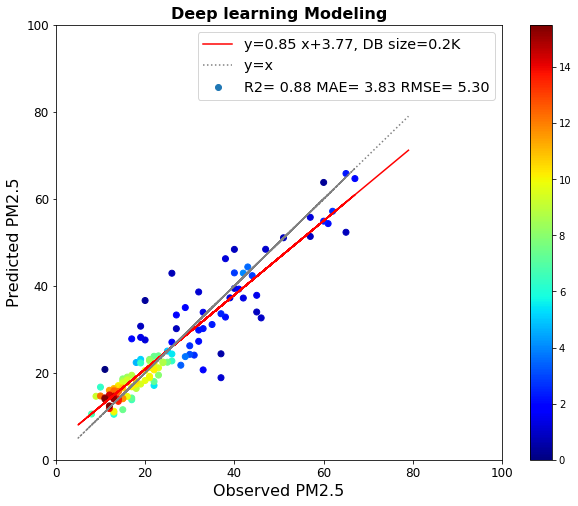

In [66]:
# ploting the results [TRAIN]
text='R2= '+format(r2, '.2f') + ' MAE= '+format(mae, '.2f')+ ' RMSE= '+format(rmse_value, '.2f')
ax,fig1,z=density_scatter( y_testinv.reshape(len(y_testinv)), y_predinv, bins = [15,15] , figsize=(10,8))
ax.set_title('Deep learning Modeling'  , fontsize=16,fontweight='bold')
pol_text='y=%.2f x+%.2f, DB size=%0.1fK' % (z[0],z[1],(dataset_size/1000))
ax.set_xlabel("Observed PM2.5", fontsize=16)
ax.set_ylabel("Predicted PM2.5", fontsize=16)
ax.legend([pol_text,'y=x ',text], fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.patch.set_facecolor('white')
ax.set_ylim(0,100)
ax.set_xlim(0,100)

### Evaluate with Test dataset

In [68]:
# evaluting the model using TEST dataset    
dfte= pd.DataFrame( columns=['features','r2','mae','rmse'])

y_pred = model.predict(test_data)
y_predinv = scalery.inverse_transform(y_pred)
y_testinv = scalery.inverse_transform(test_targets)     
mae=mean_absolute_error(y_testinv, y_predinv)
r2=r2_score( y_testinv, y_predinv)
rmse_value= rmse(y_testinv, y_predinv)
mape = mape(y_testinv, y_predinv)
print(' R2 = %.3f '  % r2 )
print(' MAE = %.3f '  % mae)
print(' RMSE = %.3f '  % rmse_value )
print(' MAPE = %.3f' % mape)
print(r2,'  ',mae,' ', rmse_value)
data=['No', r2, mae, rmse_value] 
dftn=dfte.append(pd.DataFrame(  [data]  , columns=['features','r2','mae','rmse']))

2/2 [==============================] - 0s 4ms/step
 R2 = 0.676 
 MAE = 6.748 
 RMSE = 10.056 
 MAPE = 26.285
0.6763161385063081    6.748289593943843   10.055557807452333


[0.72070846 5.48609691]


(0.0, 100.0)

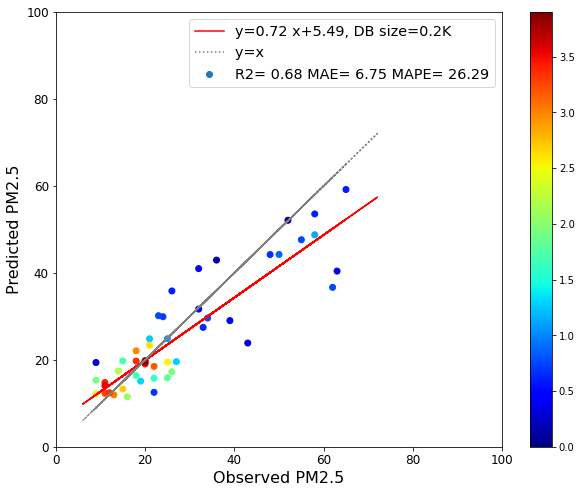

In [69]:
# ploting the results [TEST]
text='R2= '+format(r2, '.2f') + ' MAE= '+format(mae, '.2f')+ ' MAPE= '+format(mape, '.2f')
#' RMSE= '+format(rmse_value, '.2f')
ax,fig1,z=density_scatter( y_testinv.reshape(len(y_testinv)), y_predinv, bins = [15,15] , figsize=(10,8))
# ax.set_title(head , fontsize=16,fontweight='bold')
pol_text='y=%.2f x+%.2f, DB size=%0.1fK' % (z[0],z[1],(dataset_size/1000))
ax.set_xlabel("Observed PM2.5", fontsize=16)
ax.set_ylabel("Predicted PM2.5", fontsize=16)
ax.legend([pol_text,'y=x ',text], fontsize='x-large')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.patch.set_facecolor('white')
ax.set_ylim(0,100)
ax.set_xlim(0,100)